In [1]:
import bz2
import os
import os.path as osp
import sys

import cv2
import dlib
import numpy as np
import requests
import scipy.ndimage
from PIL import Image
from tqdm import tqdm

LANDMARKS_MODEL_URL = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"

In [2]:
class LandmarksDetector:
    def __init__(self, predictor_model_path):
        """
        :param predictor_model_path: path to shape_predictor_68_face_landmarks.dat file
        """
        self.detector = (
            dlib.get_frontal_face_detector()
        )  # cnn_face_detection_model_v1 also can be used
        self.shape_predictor = dlib.shape_predictor(predictor_model_path)

    def get_landmarks(self, image):
        img = cv2.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        dets = self.detector(img, 1)

        for detection in dets:
            face_landmarks = [
                (item.x, item.y)
                for item in self.shape_predictor(img, detection).parts()
            ]
            return face_landmarks


def unpack_bz2(src_path):
    dst_path = src_path[:-4]
    if os.path.exists(dst_path):
        print("cached")
        return dst_path
    data = bz2.BZ2File(src_path).read()
    with open(dst_path, "wb") as fp:
        fp.write(data)
    return dst_path


def work_landmark(raw_img_path, img_name, face_landmarks):
    face_img_name = "%s.jpg" % (os.path.splitext(img_name)[0],)
    aligned_face_path = os.path.join(ALIGNED_IMAGES_DIR, face_img_name)
    if os.path.exists(aligned_face_path):
        return
    image_align(raw_img_path, aligned_face_path, face_landmarks, output_size=256)


def get_file(src, tgt):
    if os.path.exists(tgt):
        print("cached")
        return tgt
    tgt_dir = os.path.dirname(tgt)
    if not os.path.exists(tgt_dir):
        os.makedirs(tgt_dir)
    file = requests.get(src)
    open(tgt, "wb").write(file.content)
    return tgt

In [3]:
landmarks_model_path = unpack_bz2(
    get_file(
        "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2",
        "temp/shape_predictor_68_face_landmarks.dat.bz2",
    )
)

cached
cached


In [4]:
img_dir = "imgs_align/"  # 語尾に「/」つける
dir_list = sorted(os.listdir(img_dir))
for i, file in enumerate(dir_list):
    print(f"{i}: {file}")

0: azuki_default.png
1: ceo_default.png
2: check1.png
3: check2.png
4: danda_default.png
5: detective.png
6: detective_02.png
7: idPhoto.png
8: mio_happy.png
9: mio_shock.png
10: mio_silence.png
11: mio_u.png
12: nanko_default.png
13: ookawa_angry.png
14: ookawa_angry2.png
15: ookawa_default.png
16: ookawa_high.png
17: ookawa_regret.png
18: ookawa_smile.png
19: ookawa_surprised.png
20: pharmacist.png
21: saki.png
22: saki_glasses.png
23: sandy.png
24: takebe_default.png
25: test01.png
26: test01_02.png
27: test01_03.png
28: test01_04.png
29: test02.png
30: woman_default.png
31: yotaka_angry.png
32: yotaka_angry2.png
33: yotaka_bald.png
34: yotaka_bushy.png
35: yotaka_default.png
36: yotaka_gj.png
37: yotaka_smile.png
38: yotaka_smile2.png


## 選択

In [24]:
# [from,to]の順で２画像選択
indices = [35,37]
IMAGES = []
IMAGES_NAME = []
LANDMARKS = []
for i in indices:
    img_path = img_dir + dir_list[i]
    img_name = os.path.splitext(dir_list[i])[0]
    IMAGES_NAME.append(img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    IMAGES.append(img)
    landmarks_detector = LandmarksDetector(landmarks_model_path)
    landmark = landmarks_detector.get_landmarks(img_path)
    LANDMARKS.append(landmark)

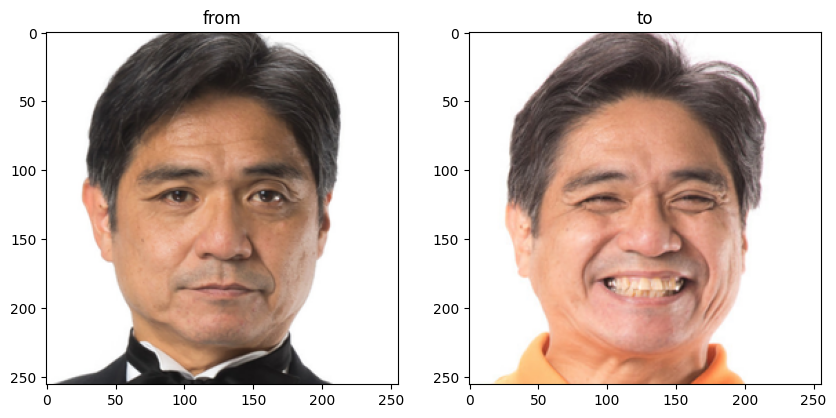

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
title = ["from", "to"]
for i in range(2):
    ax[i].imshow(IMAGES[i])
    # ax[i].axis('off')
    ax[i].set_title(title[i])

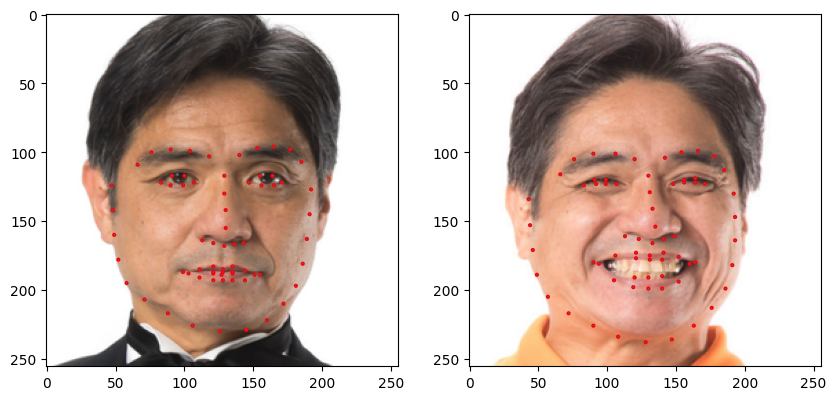

In [26]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, land in enumerate(LANDMARKS):
    ax[i].imshow(IMAGES[i])
    for la in land:
        r = patches.Circle(xy=la, radius=1, ec="r")
        ax[i].add_patch(r)

plt.show()

In [27]:
lm = np.array(LANDMARKS)
lm_eyebrow_left = lm[:, 17:22]  # left-right
lm_eyebrow_right = lm[:, 22:27]  # left-right
lm_nose = lm[:, 27:31]  # top-down
lm_nostrils = lm[:, 31:36]  # top-down
lm_eye_left = lm[:, 36:42]  # left-clockwise
lm_eye_right = lm[:, 42:48]  # left-clockwise
lm_mouth_outer = lm[:, 48:60]  # left-clockwise
lm_mouth_inner = lm[:, 60:68]  # left-clockwise

## all

In [274]:
img_from = IMAGES[0].copy()
img_to = IMAGES[1].copy()
pt_from = np.concatenate([lm[0, :17], np.flipud(lm[0, 17:27])])
pt_to = np.concatenate([lm[1, :17], np.flipud(lm[1, 17:27])])

**マスク範囲を若干小さくする（必要であれば実行）**

In [275]:
# pt_from
pt_from_center = pt_from.sum(axis=0) // len(pt_from)
for i in range(17):
    if pt_from[i][0] < pt_from_center[0]:
        pt_from[i][0] += 3
    else:
        pt_from[i][0] -= 3

    if pt_from[i][1] < pt_from_center[1]:
        pt_from[i][1] += 3
    else:
        pt_from[i][1] -= 3

for i in range(17, 27):
    pt_from[i][1] -= 8

# pt_to
pt_to_center = pt_to.sum(axis=0) // len(pt_to)
for i in range(17):
    if pt_to[i][0] < pt_to_center[0]:
        pt_to[i][0] += 3
    else:
        pt_to[i][0] -= 3

    if pt_to[i][1] < pt_to_center[1]:
        pt_to[i][1] += 3
    else:
        pt_to[i][1] -= 3

for i in range(17, 27):
    pt_to[i][1] -= 8

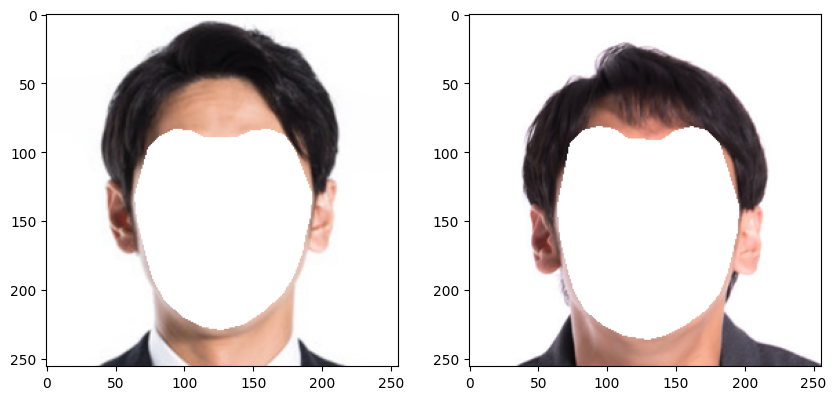

In [276]:
import matplotlib.pyplot as plt

fill_color = (255, 255, 255)
cv2.fillPoly(img_from, [pt_from], fill_color)
cv2.fillPoly(img_to, [pt_to], fill_color)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_from)
ax[1].imshow(img_to)

plt.show()

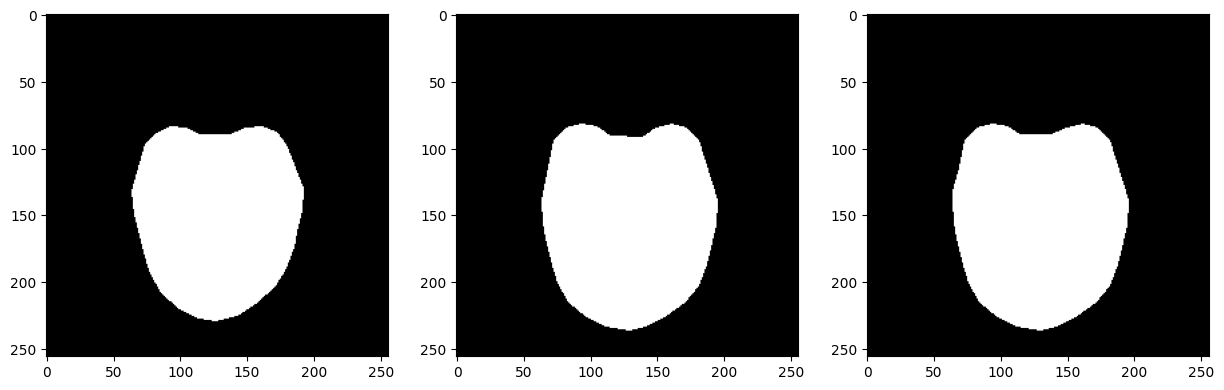

In [277]:
mask = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
mask_from = cv2.fillPoly(mask.copy(), [pt_from], (255, 255, 255))
mask_to = cv2.fillPoly(mask.copy(), [pt_to], (255, 255, 255))
mask_or = mask_from | mask_to

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(mask_from)
ax[1].imshow(mask_to)
ax[2].imshow(mask_or)
plt.show()

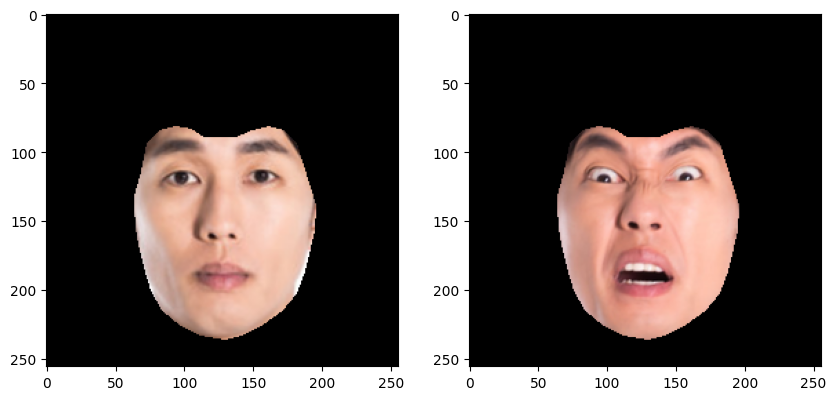

In [278]:
crop = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
crop_from = cv2.bitwise_and(IMAGES[0], mask_or)
crop_to = cv2.bitwise_and(IMAGES[1], mask_or)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(crop_from)
ax[1].imshow(crop_to)
plt.show()

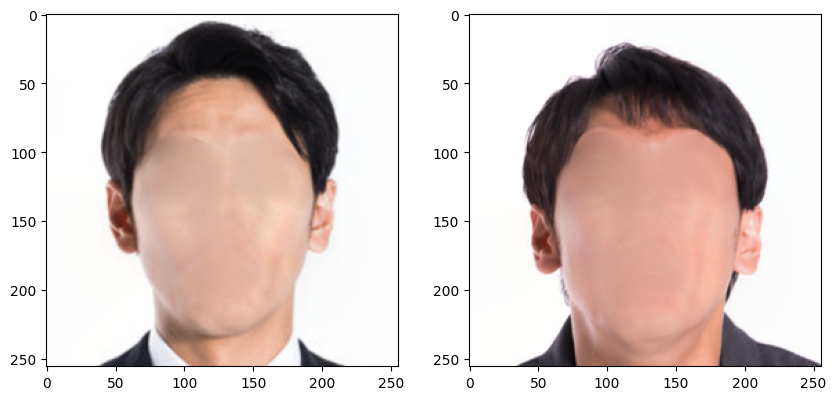

In [279]:
faceless_from = cv2.illuminationChange(IMAGES[0], mask_from, alpha=2, beta=2)
faceless_to = cv2.illuminationChange(IMAGES[1], mask_to, alpha=2, beta=2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(faceless_from)
ax[1].imshow(faceless_to)
plt.show()

## eye

In [28]:
img_eye_from = IMAGES[0].copy()
img_eye_to = IMAGES[1].copy()
pt_eye_left_from = np.vstack([lm[0, 17:22], lm[0, 39:42], lm[0, 36]])
pt_eye_right_from = np.vstack([lm[0, 22:27], lm[0, 45:48], lm[0, 42]])
pt_eye_left_to = np.vstack([lm[1, 17:22], lm[1, 39:42], lm[1, 36]])
pt_eye_right_to = np.vstack([lm[1, 22:27], lm[1, 45:48], lm[1, 42]])

In [29]:
pt_eye_left_from_center = pt_eye_left_from.sum(axis=0) // len(pt_eye_left_from)
for i in range(len(pt_eye_left_from)):
    if pt_eye_left_from[i][0] < pt_eye_left_from_center[0]:
        pt_eye_left_from[i][0] -= 8
    else:
        pt_eye_left_from[i][0] += 8

    if pt_eye_left_from[i][1] < pt_eye_left_from_center[1]:
        pt_eye_left_from[i][1] -= 8
    else:
        pt_eye_left_from[i][1] += 13

pt_eye_right_from_center = pt_eye_right_from.sum(axis=0) // len(pt_eye_right_from)
for i in range(len(pt_eye_right_from)):
    if pt_eye_right_from[i][0] < pt_eye_right_from_center[0]:
        pt_eye_right_from[i][0] -= 8
    else:
        pt_eye_right_from[i][0] += 8

    if pt_eye_right_from[i][1] < pt_eye_right_from_center[1]:
        pt_eye_right_from[i][1] -= 8
    else:
        pt_eye_right_from[i][1] += 13

pt_eye_left_to_center = pt_eye_left_to.sum(axis=0) // len(pt_eye_left_to)
for i in range(len(pt_eye_left_to)):
    if pt_eye_left_to[i][0] < pt_eye_left_to_center[0]:
        pt_eye_left_to[i][0] -= 8
    else:
        pt_eye_left_to[i][0] += 8

    if pt_eye_left_to[i][1] < pt_eye_left_to_center[1]:
        pt_eye_left_to[i][1] -= 8
    else:
        pt_eye_left_to[i][1] += 13

pt_eye_right_to_center = pt_eye_right_to.sum(axis=0) // len(pt_eye_right_to)
for i in range(len(pt_eye_right_to)):
    if pt_eye_right_to[i][0] < pt_eye_right_to_center[0]:
        pt_eye_right_to[i][0] -= 8
    else:
        pt_eye_right_to[i][0] += 8

    if pt_eye_right_to[i][1] < pt_eye_right_to_center[1]:
        pt_eye_right_to[i][1] -= 8
    else:
        pt_eye_right_to[i][1] += 13

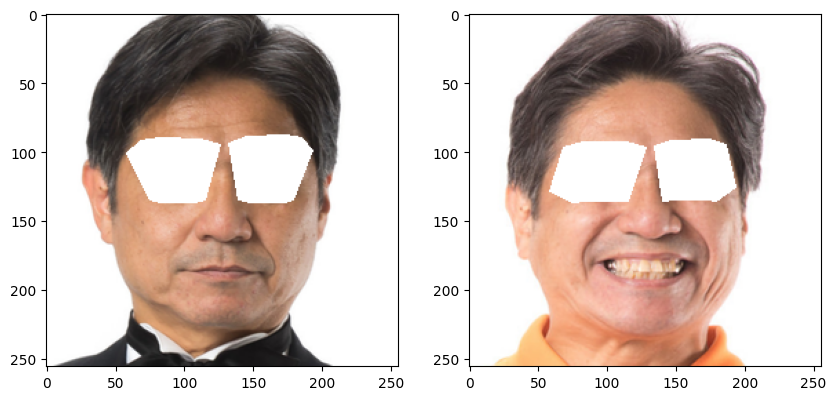

In [30]:
import matplotlib.pyplot as plt

fill_color = (255, 255, 255)
cv2.fillPoly(img_eye_from, [pt_eye_left_from], fill_color)
cv2.fillPoly(img_eye_from, [pt_eye_right_from], fill_color)
cv2.fillPoly(img_eye_to, [pt_eye_left_to], fill_color)
cv2.fillPoly(img_eye_to, [pt_eye_right_to], fill_color)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_eye_from)
ax[1].imshow(img_eye_to)

plt.show()

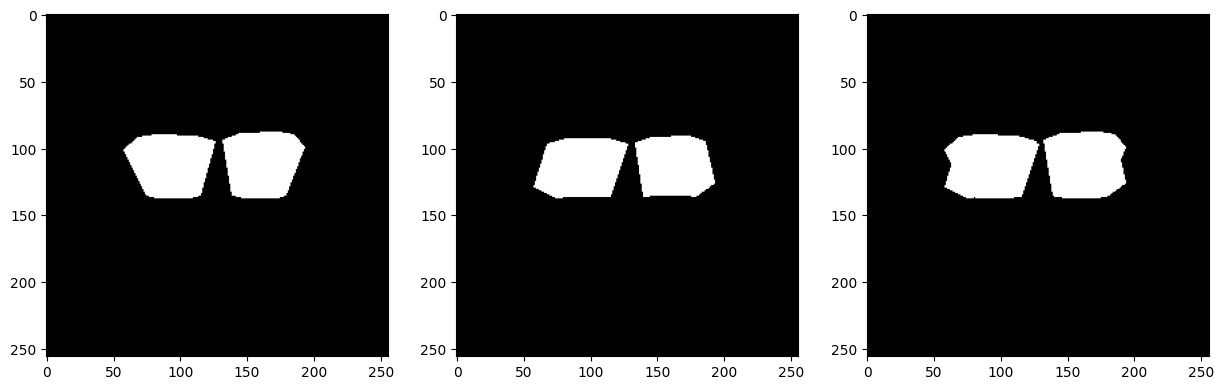

In [44]:
mask = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
mask_eye_from = cv2.fillPoly(mask.copy(), [pt_eye_left_from], (255, 255, 255))
cv2.fillPoly(mask_eye_from, [pt_eye_right_from], (255, 255, 255))
mask_eye_to = cv2.fillPoly(mask.copy(), [pt_eye_left_to], (255, 255, 255))
cv2.fillPoly(mask_eye_to, [pt_eye_right_to], (255, 255, 255))
mask_eye_or = mask_eye_from | mask_eye_to

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(mask_eye_from)
ax[1].imshow(mask_eye_to)
ax[2].imshow(mask_eye_or)
plt.show()

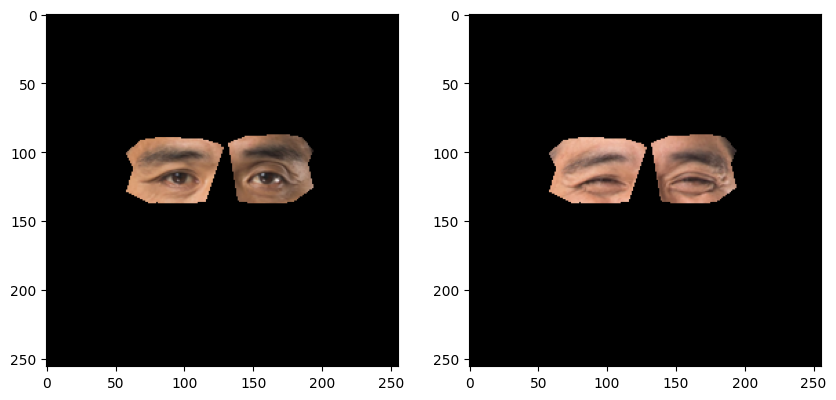

In [42]:
crop_eye = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
crop_eye_from = cv2.bitwise_and(IMAGES[0], mask_eye_or)
crop_eye_to = cv2.bitwise_and(IMAGES[1], mask_eye_or)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(crop_eye_from)
ax[1].imshow(crop_eye_to)
plt.show()

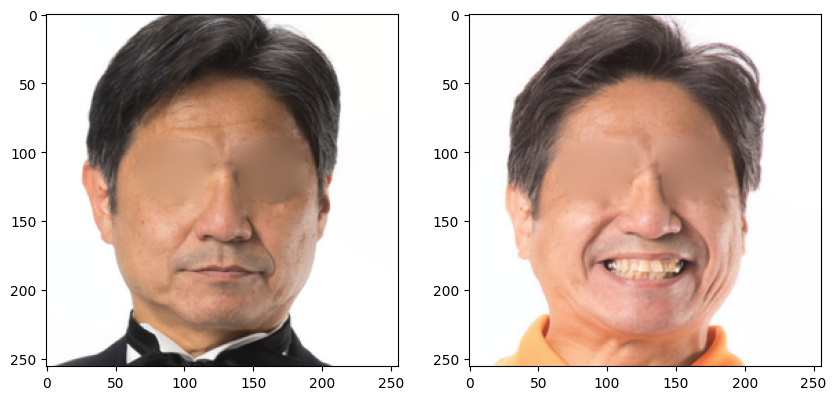

In [34]:
eyeless_from = cv2.illuminationChange(IMAGES[0], mask_eye_or, alpha=2, beta=2)
eyeless_to = cv2.illuminationChange(IMAGES[1], mask_eye_or, alpha=2, beta=2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(eyeless_from)
ax[1].imshow(eyeless_to)
plt.show()

## eye2

eyeを実行してから

In [286]:
img_eye2_from = IMAGES[0].copy()
img_eye2_to = IMAGES[1].copy()

pt_eye2_from = np.vstack([
    pt_eye_left_from.copy()[:5],
    pt_eye_right_from.copy(),
    pt_eye_left_from.copy()[5:]
])
pt_eye2_to = np.vstack([
    pt_eye_left_to.copy()[:5],
    pt_eye_right_to.copy(),
    pt_eye_left_to.copy()[5:]
])

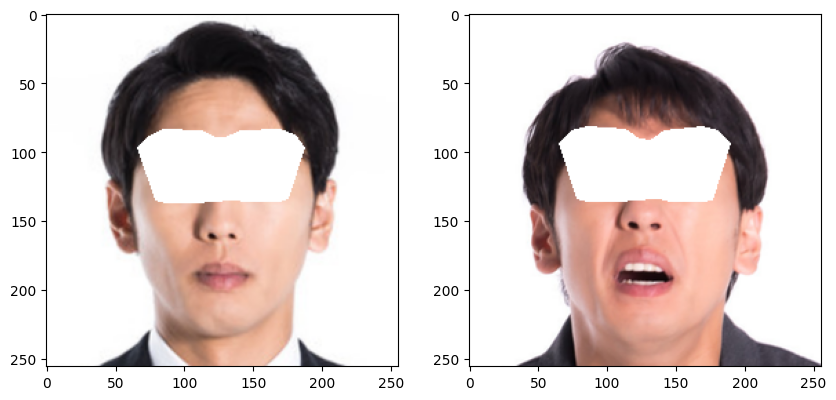

In [287]:
import matplotlib.pyplot as plt

fill_color = (255, 255, 255)
cv2.fillPoly(img_eye2_from, [pt_eye2_from], fill_color)
cv2.fillPoly(img_eye2_to, [pt_eye2_to], fill_color)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_eye2_from)
ax[1].imshow(img_eye2_to)

plt.show()

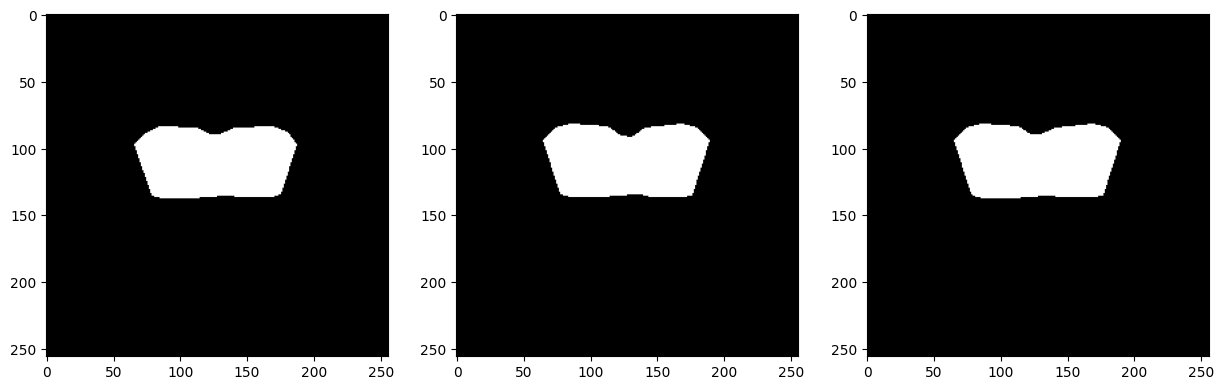

In [288]:
mask = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
mask_eye2_from = cv2.fillPoly(mask.copy(), [pt_eye2_from], (255, 255, 255))
mask_eye2_to = cv2.fillPoly(mask.copy(), [pt_eye2_to], (255, 255, 255))
mask_eye2_or = mask_eye2_from | mask_eye2_to

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(mask_eye2_from)
ax[1].imshow(mask_eye2_to)
ax[2].imshow(mask_eye2_or)
plt.show()

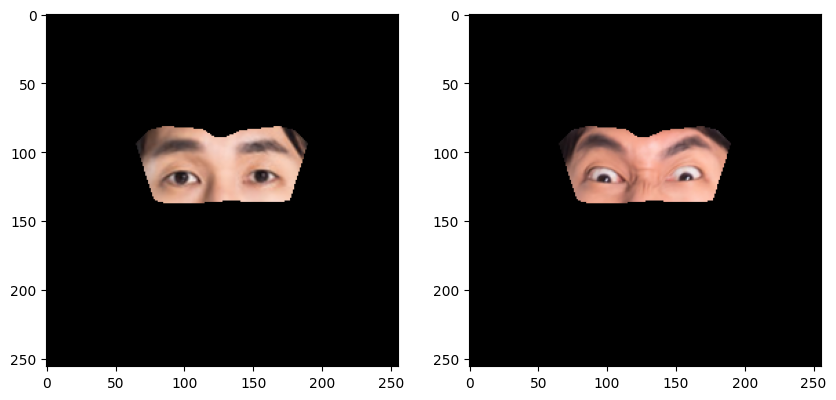

In [289]:
crop_eye2 = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
crop_eye2_from = cv2.bitwise_and(IMAGES[0], mask_eye2_or)
crop_eye2_to = cv2.bitwise_and(IMAGES[1], mask_eye2_or)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(crop_eye2_from)
ax[1].imshow(crop_eye2_to)
plt.show()

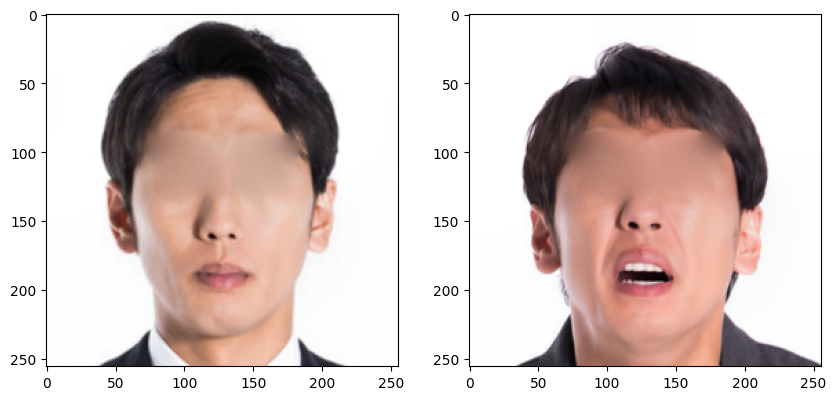

In [290]:
eye2less_from = cv2.illuminationChange(IMAGES[0], mask_eye2_or, alpha=2, beta=2)
eye2less_to = cv2.illuminationChange(IMAGES[1], mask_eye2_or, alpha=2, beta=2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(eye2less_from)
ax[1].imshow(eye2less_to)
plt.show()

## mouth

In [291]:
img_mouth_from = IMAGES[0].copy()
img_mouth_to = IMAGES[1].copy()
pt_mouth_from = lm[0, 48:60].copy()
pt_mouth_to = lm[1, 48:60].copy()

In [292]:
pt_mouth_from_center = pt_mouth_from.sum(axis=0) // len(pt_mouth_from)
for i in range(len(pt_mouth_from)):
    if pt_mouth_from[i][0] < pt_mouth_from_center[0]:
        pt_mouth_from[i][0] -= 15
    else:
        pt_mouth_from[i][0] += 15

    if pt_mouth_from[i][1] < pt_mouth_from_center[1]:
        pt_mouth_from[i][1] -= 10
    else:
        pt_mouth_from[i][1] += 10

pt_mouth_to_center = pt_mouth_to.sum(axis=0) // len(pt_mouth_to)
for i in range(len(pt_mouth_to)):
    if pt_mouth_to[i][0] < pt_mouth_to_center[0]:
        pt_mouth_to[i][0] -= 15
    else:
        pt_mouth_to[i][0] += 15

    if pt_mouth_to[i][1] < pt_mouth_to_center[1]:
        pt_mouth_to[i][1] -= 10
    else:
        pt_mouth_to[i][1] += 10

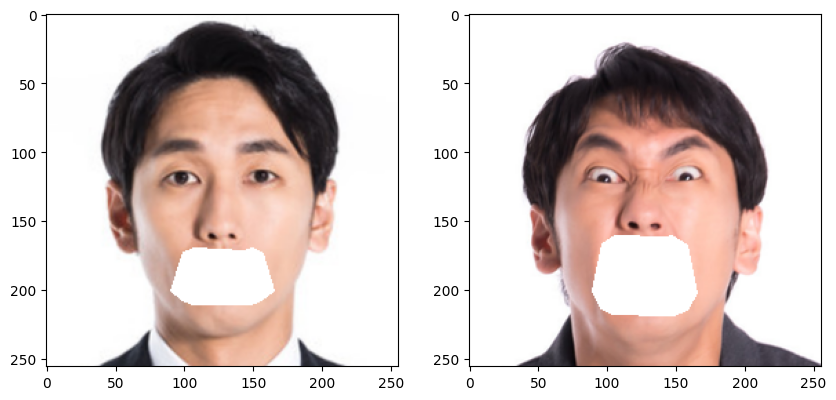

In [293]:
import matplotlib.pyplot as plt

fill_color = (255, 255, 255)
cv2.fillPoly(img_mouth_from, [pt_mouth_from], fill_color)
cv2.fillPoly(img_mouth_to, [pt_mouth_to], fill_color)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_mouth_from)
ax[1].imshow(img_mouth_to)

plt.show()

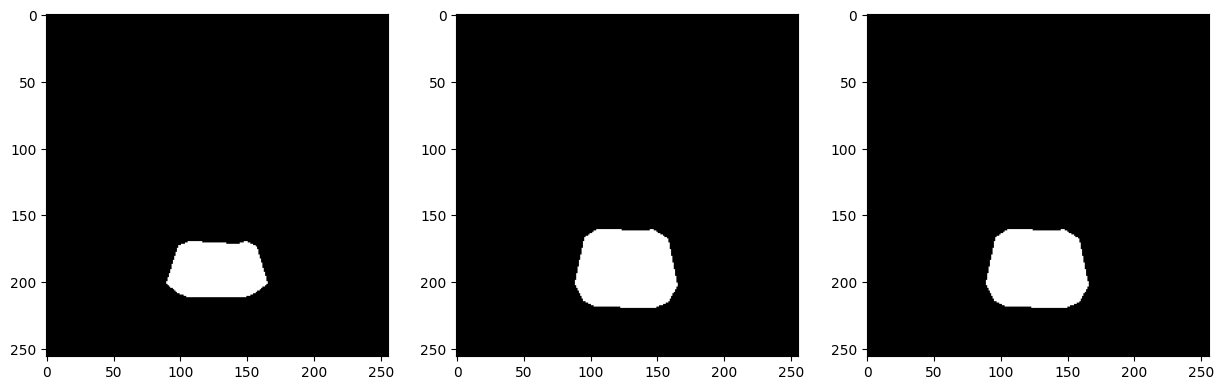

In [294]:
mask = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
mask_mouth_from = cv2.fillPoly(mask.copy(), [pt_mouth_from], (255, 255, 255))
mask_mouth_to = cv2.fillPoly(mask.copy(), [pt_mouth_to], (255, 255, 255))
mask_mouth_or = mask_mouth_from | mask_mouth_to

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(mask_mouth_from)
ax[1].imshow(mask_mouth_to)
ax[2].imshow(mask_mouth_or)
plt.show()

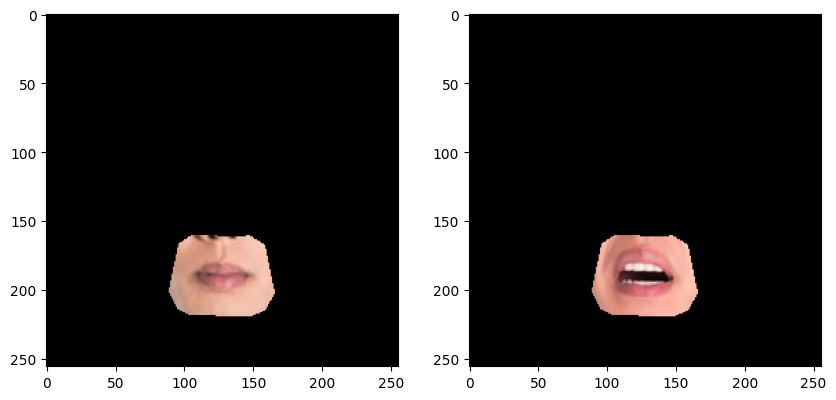

In [295]:
crop_mouth = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
crop_mouth_from = cv2.bitwise_and(IMAGES[0], mask_mouth_or)
crop_mouth_to = cv2.bitwise_and(IMAGES[1], mask_mouth_or)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(crop_mouth_from)
ax[1].imshow(crop_mouth_to)
plt.show()

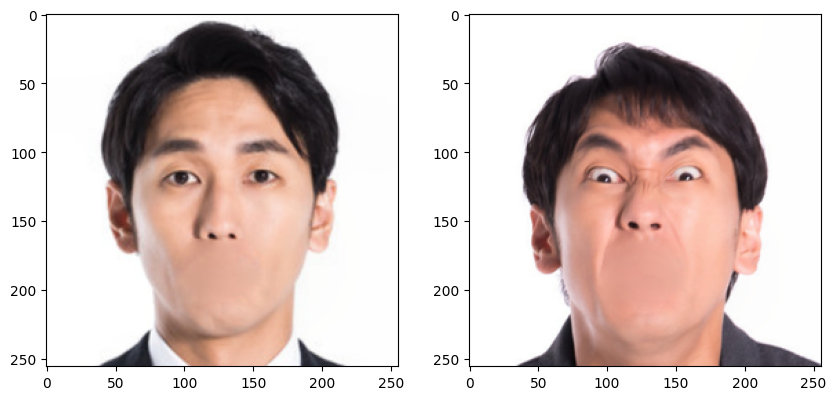

In [296]:
mouthless_from = cv2.illuminationChange(IMAGES[0], mask_mouth_or, alpha=2, beta=2)
mouthless_to = cv2.illuminationChange(IMAGES[1], mask_mouth_or, alpha=2, beta=2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(mouthless_from)
ax[1].imshow(mouthless_to)
plt.show()

## eye&mouth

eye, mouthを実行してから

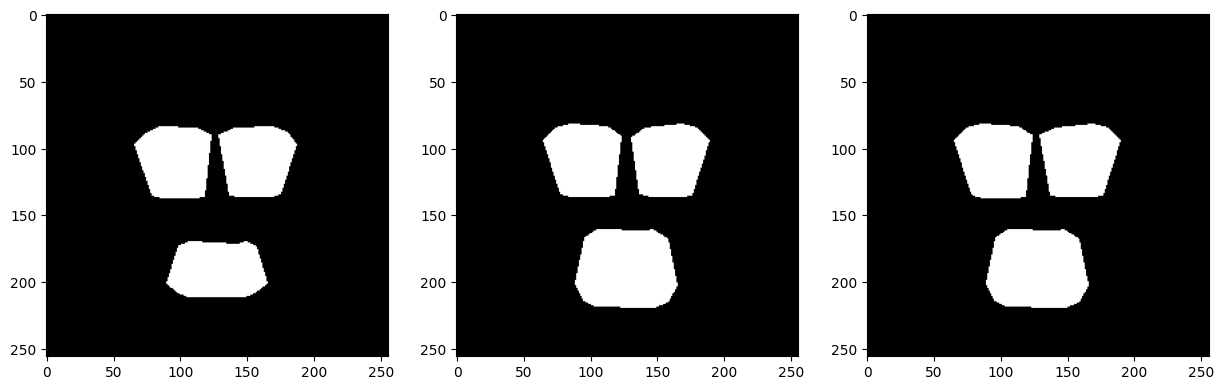

In [297]:
mask_eye_mouth_from = cv2.fillPoly(mask_eye_from.copy(), [pt_mouth_from], (255, 255, 255))
mask_eye_mouth_to = cv2.fillPoly(mask_eye_to.copy(), [pt_mouth_to], (255, 255, 255))
mask_eye_mouth_or = mask_eye_mouth_from | mask_eye_mouth_to

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(mask_eye_mouth_from)
ax[1].imshow(mask_eye_mouth_to)
ax[2].imshow(mask_eye_mouth_or)
plt.show()

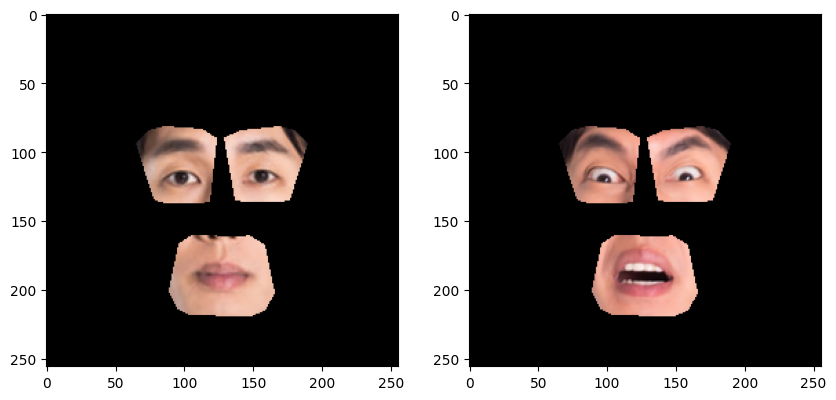

In [298]:
crop_eye_mouth = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
crop_eye_mouth_from = cv2.bitwise_and(IMAGES[0], mask_eye_mouth_or)
crop_eye_mouth_to = cv2.bitwise_and(IMAGES[1], mask_eye_mouth_or)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(crop_eye_mouth_from)
ax[1].imshow(crop_eye_mouth_to)
plt.show()

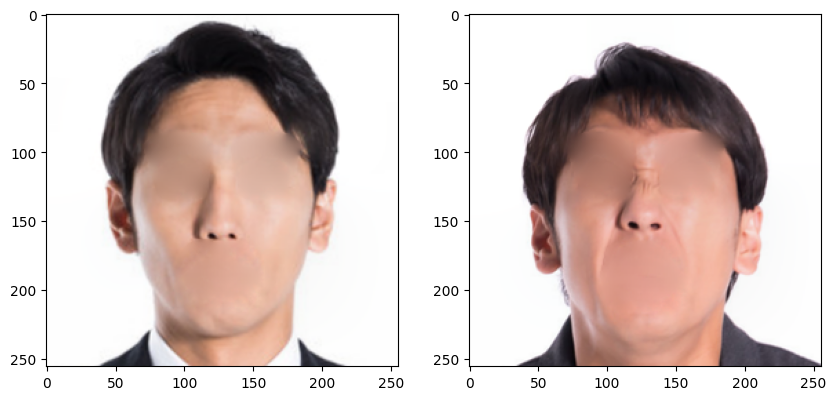

In [299]:
eye_mouth_less_from = cv2.illuminationChange(
    IMAGES[0], mask_eye_mouth_or, alpha=2, beta=2
)
eye_mouth_less_to = cv2.illuminationChange(
    IMAGES[1], mask_eye_mouth_or, alpha=2, beta=2
)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(eye_mouth_less_from)
ax[1].imshow(eye_mouth_less_to)
plt.show()

## eye2&mouth

eye2, mouthを実行してから

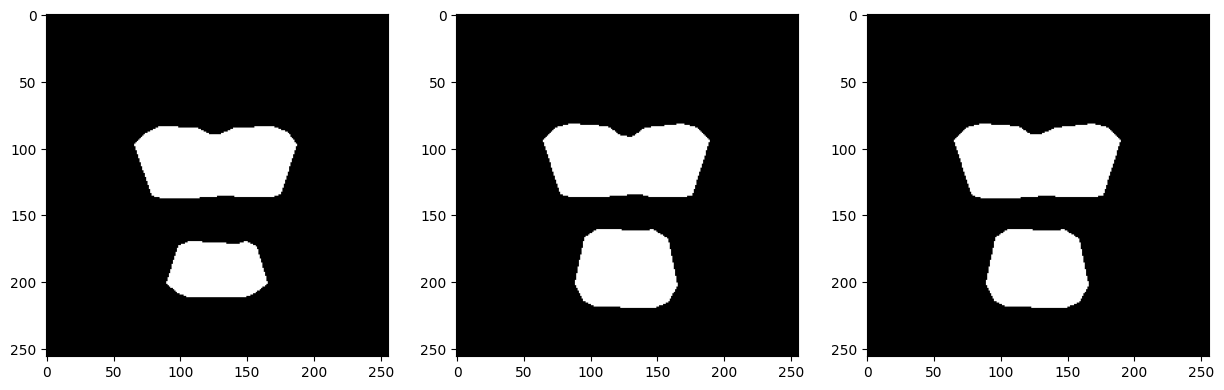

In [300]:
mask_eye2_mouth_from = cv2.fillPoly(mask_eye2_from.copy(), [pt_mouth_from], (255, 255, 255))
mask_eye2_mouth_to = cv2.fillPoly(mask_eye2_to.copy(), [pt_mouth_to], (255, 255, 255))
mask_eye2_mouth_or = mask_eye2_mouth_from | mask_eye2_mouth_to

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(mask_eye2_mouth_from)
ax[1].imshow(mask_eye2_mouth_to)
ax[2].imshow(mask_eye2_mouth_or)
plt.show()

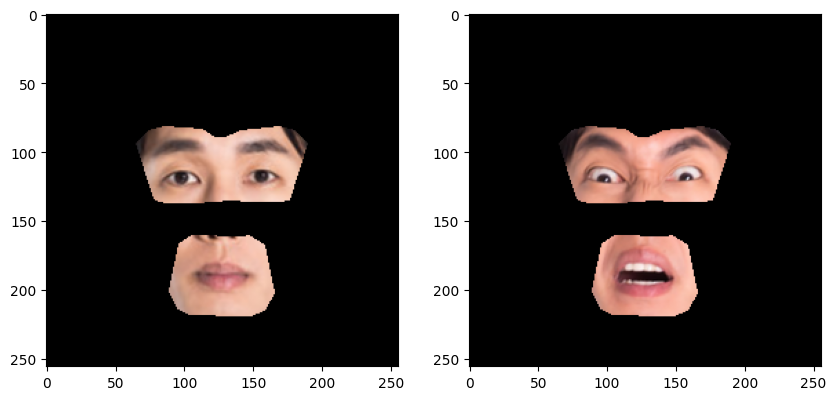

In [301]:
crop_eye2_mouth = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
crop_eye2_mouth_from = cv2.bitwise_and(IMAGES[0], mask_eye2_mouth_or)
crop_eye2_mouth_to = cv2.bitwise_and(IMAGES[1], mask_eye2_mouth_or)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(crop_eye2_mouth_from)
ax[1].imshow(crop_eye2_mouth_to)
plt.show()

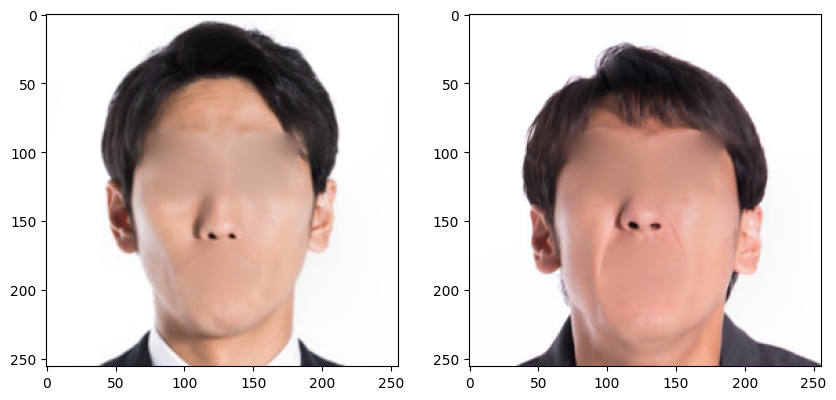

In [302]:
eye2_mouth_less_from = cv2.illuminationChange(
    IMAGES[0], mask_eye2_mouth_or, alpha=2, beta=2
)
eye2_mouth_less_to = cv2.illuminationChange(
    IMAGES[1], mask_eye2_mouth_or, alpha=2, beta=2
)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(eye2_mouth_less_from)
ax[1].imshow(eye2_mouth_less_to)
plt.show()

## mouth&nose

In [303]:
img_mouth_nose_from = IMAGES[0].copy()
img_mouth_nose_to = IMAGES[1].copy()
pt_mouth_nose_from = np.vstack([lm[0, 36], lm[0, 45], lm[0, 54:60], lm[0, 48]])
pt_mouth_nose_to = np.vstack([lm[1, 36], lm[1, 45], lm[1, 54:60], lm[1, 48]])

In [304]:
pt_mouth_nose_from_center = pt_mouth_nose_from.sum(axis=0) // len(pt_mouth_nose_from)
for i in range(len(pt_mouth_nose_from)):
    if i < 2:
        pt_mouth_nose_from[i][1] += 15
    else:    
        if pt_mouth_nose_from[i][0] < pt_mouth_nose_from_center[0]:
            pt_mouth_nose_from[i][0] -= 15
        else:
            pt_mouth_nose_from[i][0] += 15
    
        if pt_mouth_nose_from[i][1] < pt_mouth_nose_from_center[1]:
            pt_mouth_nose_from[i][1] -= 0
        else:
            pt_mouth_nose_from[i][1] += 10

pt_mouth_nose_to_center = pt_mouth_nose_to.sum(axis=0) // len(pt_mouth_nose_to)
for i in range(len(pt_mouth_nose_to)):
    if i < 2:
        pt_mouth_nose_to[i][1] += 15
    else:    
        if pt_mouth_nose_to[i][0] < pt_mouth_nose_to_center[0]:
            pt_mouth_nose_to[i][0] -= 15
        else:
            pt_mouth_nose_to[i][0] += 15
    
        if pt_mouth_nose_to[i][1] < pt_mouth_nose_to_center[1]:
            pt_mouth_nose_to[i][1] -= 0
        else:
            pt_mouth_nose_to[i][1] += 10

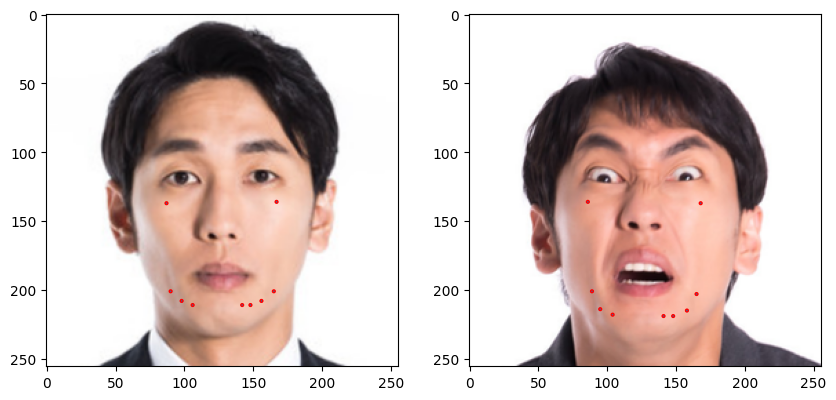

In [305]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(IMAGES[0])
for la in pt_mouth_nose_from:
    r = patches.Circle(xy=la, radius=1, ec="r")
    ax[0].add_patch(r)
    
ax[1].imshow(IMAGES[1])
for la in pt_mouth_nose_to:
    r = patches.Circle(xy=la, radius=1, ec="r")
    ax[1].add_patch(r)
plt.show()

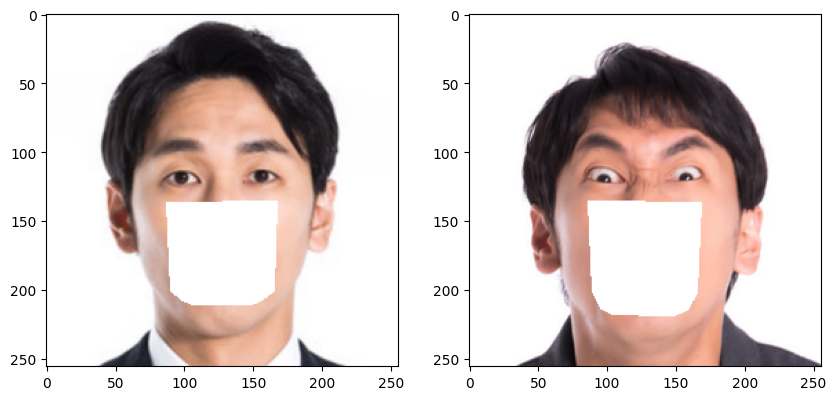

In [306]:
import matplotlib.pyplot as plt

fill_color = (255, 255, 255)
cv2.fillPoly(img_mouth_nose_from, [pt_mouth_nose_from], fill_color)
cv2.fillPoly(img_mouth_nose_to, [pt_mouth_nose_to], fill_color)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_mouth_nose_from)
ax[1].imshow(img_mouth_nose_to)

plt.show()

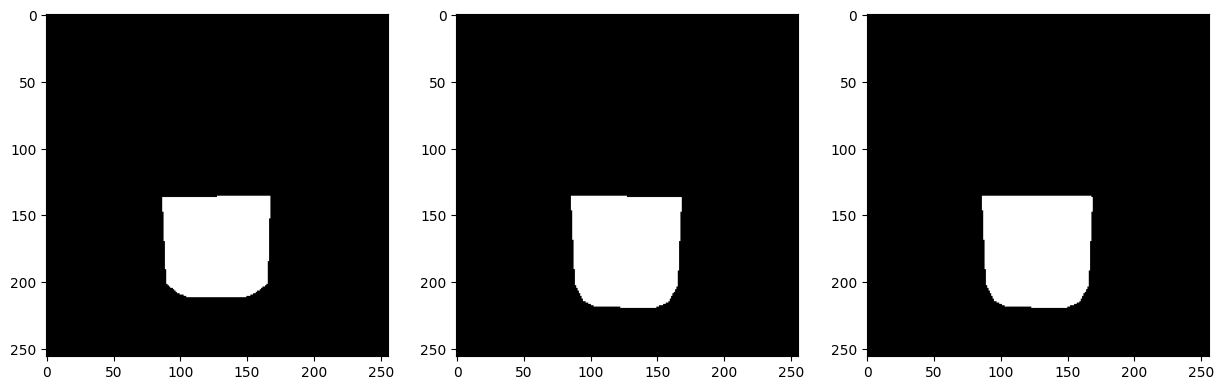

In [307]:
mask = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
mask_mouth_nose_from = cv2.fillPoly(mask.copy(), [pt_mouth_nose_from], (255, 255, 255))
mask_mouth_nose_to = cv2.fillPoly(mask.copy(), [pt_mouth_nose_to], (255, 255, 255))
mask_mouth_nose_or = mask_mouth_nose_from | mask_mouth_nose_to

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(mask_mouth_nose_from)
ax[1].imshow(mask_mouth_nose_to)
ax[2].imshow(mask_mouth_nose_or)
plt.show()

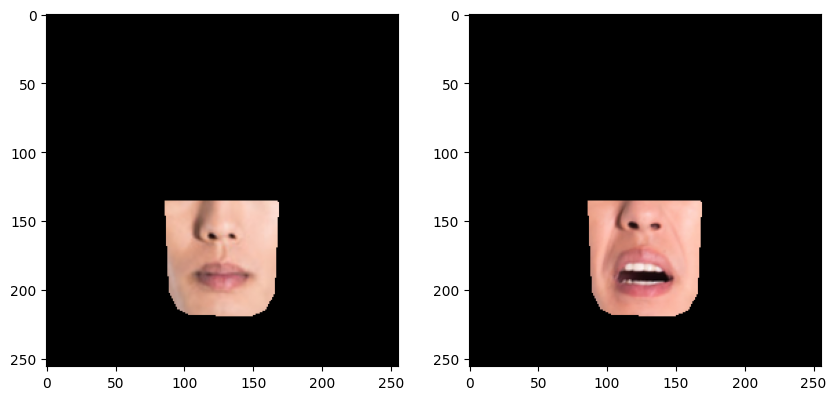

In [308]:
crop_mouth_nose = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
crop_mouth_nose_from = cv2.bitwise_and(IMAGES[0], mask_mouth_nose_or)
crop_mouth_nose_to = cv2.bitwise_and(IMAGES[1], mask_mouth_nose_or)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(crop_mouth_nose_from)
ax[1].imshow(crop_mouth_nose_to)
plt.show()

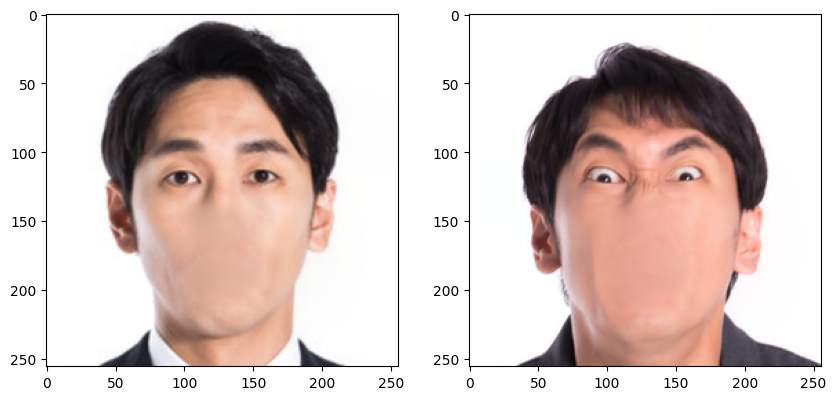

In [309]:
mouth_nose_less_from = cv2.illuminationChange(IMAGES[0], mask_mouth_nose_or, alpha=2, beta=2)
mouth_nose_less_to = cv2.illuminationChange(IMAGES[1], mask_mouth_nose_or, alpha=2, beta=2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(mouth_nose_less_from)
ax[1].imshow(mouth_nose_less_to)
plt.show()

## 合成

### face-all

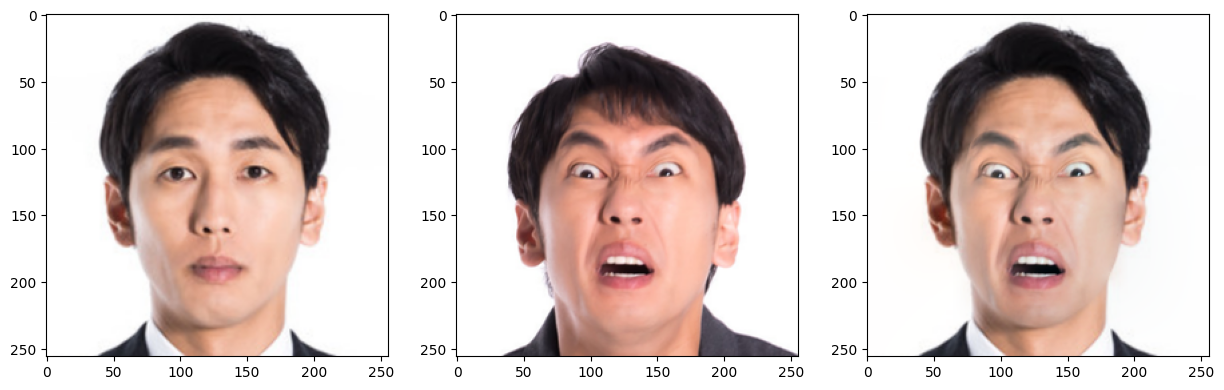

In [310]:
monoMaskImage = cv2.split(mask_to)[0] # reducing the mask to a monochrome
br = cv2.boundingRect(monoMaskImage) # bounding rect (x,y,width,height)
center = (br[0] + br[2] // 2, br[1] + br[3] // 2)
result = cv2.seamlessClone(IMAGES[1], faceless_from, mask_to, center, cv2.NORMAL_CLONE)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(IMAGES[0])
ax[1].imshow(IMAGES[1])
ax[2].imshow(result)
# for i in range(3):
#     ax[i].grid()
plt.show()

### eye

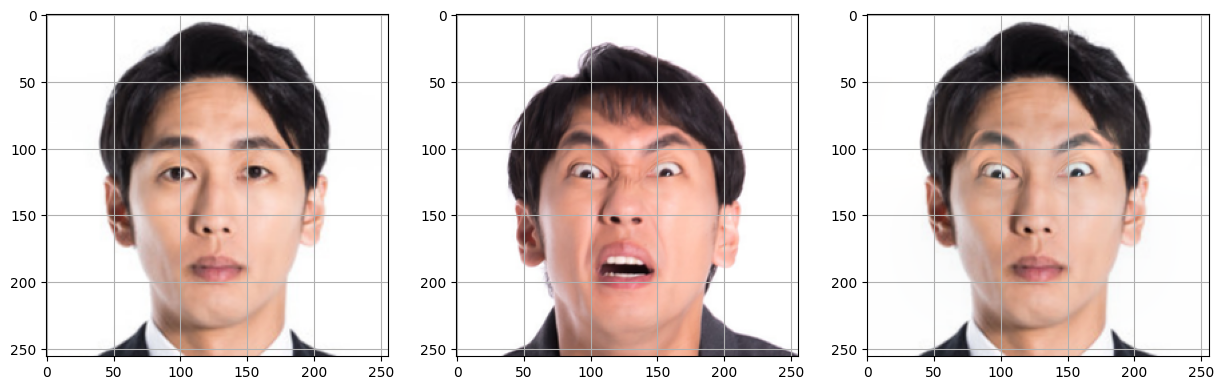

In [311]:
monoMaskImage = cv2.split(mask_eye_to)[0] # reducing the mask to a monochrome
br = cv2.boundingRect(monoMaskImage) # bounding rect (x,y,width,height)
center = (br[0] + br[2] // 2, br[1] + br[3] // 2)
result_eye = cv2.seamlessClone(IMAGES[1], eyeless_from, mask_eye_to, center, cv2.NORMAL_CLONE)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(IMAGES[0])
ax[1].imshow(IMAGES[1])
ax[2].imshow(result_eye)
for i in range(3):
    ax[i].grid()
plt.show()

### eye2

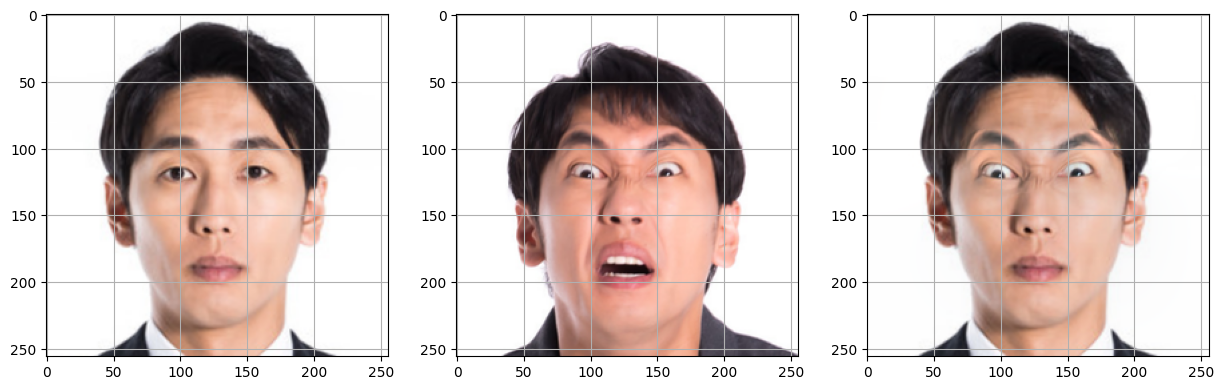

In [312]:
monoMaskImage = cv2.split(mask_eye2_to)[0] # reducing the mask to a monochrome
br = cv2.boundingRect(monoMaskImage) # bounding rect (x,y,width,height)
center = (br[0] + br[2] // 2, br[1] + br[3] // 2)
result_eye2 = cv2.seamlessClone(IMAGES[1], eye2less_from, mask_eye2_to, center, cv2.NORMAL_CLONE)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(IMAGES[0])
ax[1].imshow(IMAGES[1])
ax[2].imshow(result_eye2)
for i in range(3):
    ax[i].grid()
plt.show()

### mouth

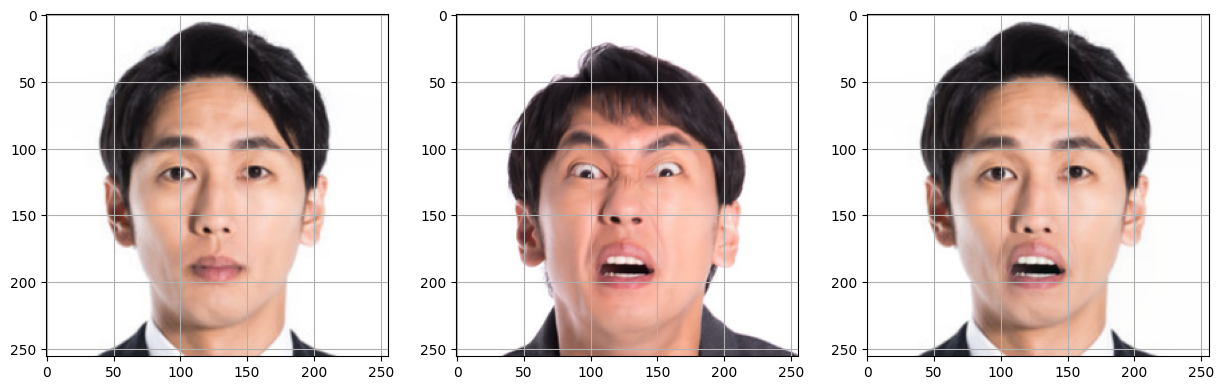

In [313]:
monoMaskImage = cv2.split(mask_mouth_to)[0] # reducing the mask to a monochrome
br = cv2.boundingRect(monoMaskImage) # bounding rect (x,y,width,height)
center = (br[0] + br[2] // 2, br[1] + br[3] // 2)
result_mouth = cv2.seamlessClone(IMAGES[1], mouthless_from, mask_mouth_to, center, cv2.NORMAL_CLONE)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(IMAGES[0])
ax[1].imshow(IMAGES[1])
ax[2].imshow(result_mouth)
for i in range(3):
    ax[i].grid()
plt.show()

### eye&mouth

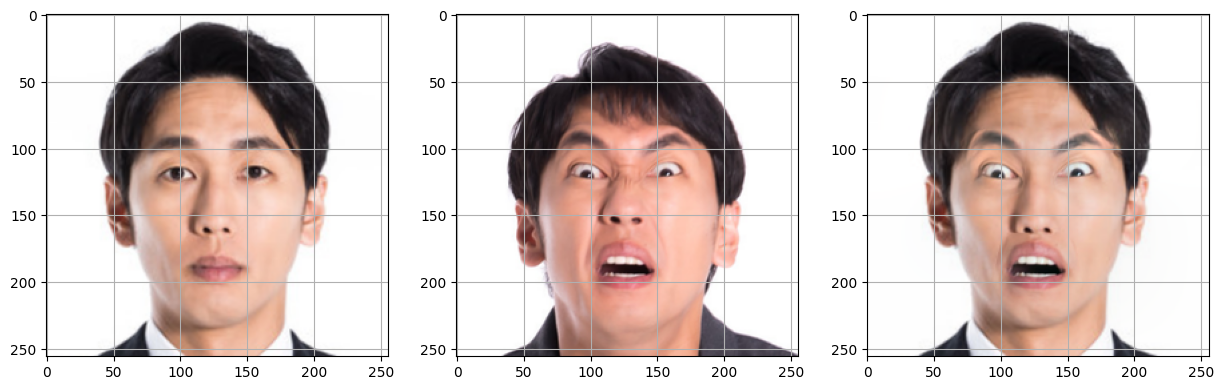

In [314]:
monoMaskImage = cv2.split(mask_eye_mouth_to)[0] # reducing the mask to a monochrome
br = cv2.boundingRect(monoMaskImage) # bounding rect (x,y,width,height)
center = (br[0] + br[2] // 2, br[1] + br[3] // 2)
result_eye_mouth = cv2.seamlessClone(IMAGES[1], eye_mouth_less_from, mask_eye_mouth_to, center, cv2.NORMAL_CLONE)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(IMAGES[0])
ax[1].imshow(IMAGES[1])
ax[2].imshow(result_eye_mouth)
for i in range(3):
    ax[i].grid()
plt.show()

### eye2&mouth

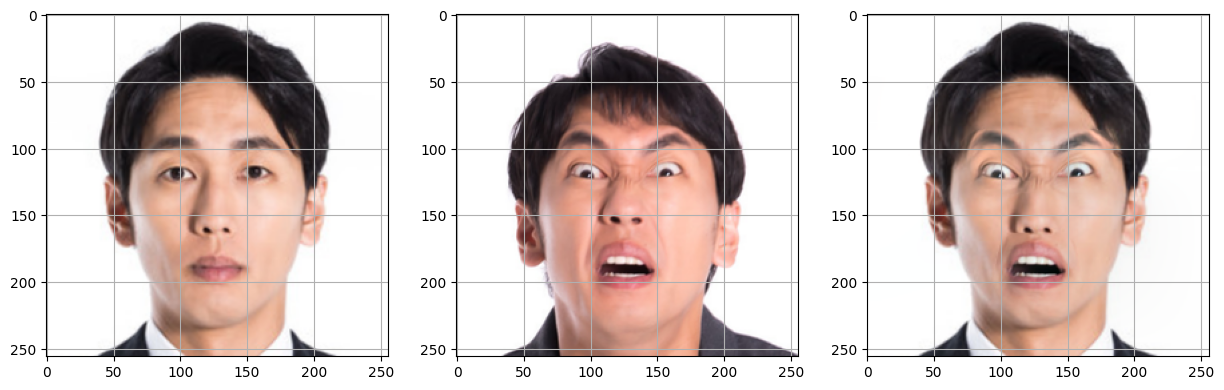

In [315]:
monoMaskImage = cv2.split(mask_eye2_mouth_to)[0] # reducing the mask to a monochrome
br = cv2.boundingRect(monoMaskImage) # bounding rect (x,y,width,height)
center = (br[0] + br[2] // 2, br[1] + br[3] // 2)
result_eye2_mouth = cv2.seamlessClone(IMAGES[1], eye2_mouth_less_from, mask_eye2_mouth_to, center, cv2.NORMAL_CLONE)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(IMAGES[0])
ax[1].imshow(IMAGES[1])
ax[2].imshow(result_eye2_mouth)
for i in range(3):
    ax[i].grid()
plt.show()

### mouth&nose

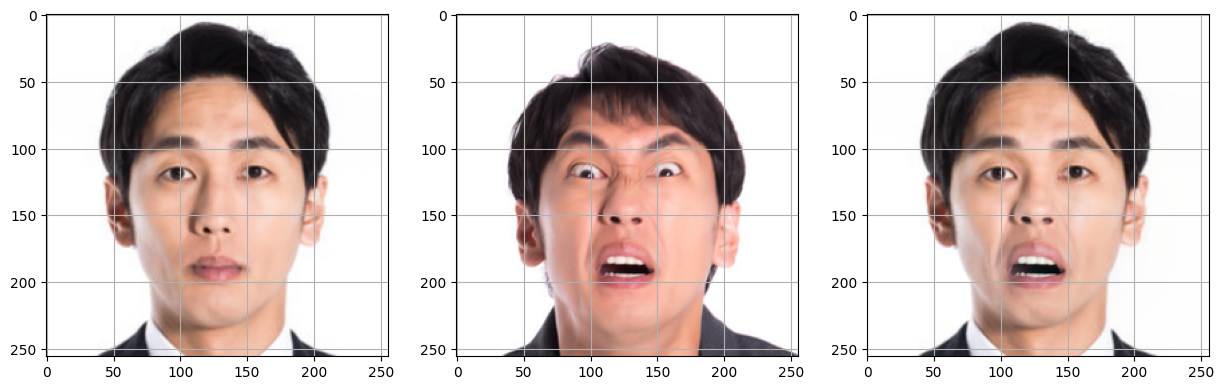

In [316]:
monoMaskImage = cv2.split(mask_mouth_nose_to)[0] # reducing the mask to a monochrome
br = cv2.boundingRect(monoMaskImage) # bounding rect (x,y,width,height)
center = (br[0] + br[2] // 2, br[1] + br[3] // 2)
result_mouth_nose = cv2.seamlessClone(IMAGES[1], mouth_nose_less_from, mask_mouth_nose_to, center, cv2.NORMAL_CLONE)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(IMAGES[0])
ax[1].imshow(IMAGES[1])
ax[2].imshow(result_mouth_nose)
for i in range(3):
    ax[i].grid()
plt.show()

## 保存

In [317]:
dst_dir = f"imgs_test/imgs_faceless/"
if not os.path.exists(f"{dst_dir}{IMAGES_NAME[0]}"):
    os.makedirs(f"{dst_dir}{IMAGES_NAME[0]}")
if not os.path.exists(f"{dst_dir}{IMAGES_NAME[1]}"):
    os.makedirs(f"{dst_dir}{IMAGES_NAME[1]}")

dst_dir_crop = f"imgs_test/imgs_crop/{IMAGES_NAME[0]}-{IMAGES_NAME[1]}/"
if not os.path.exists(dst_dir_crop):
    os.makedirs(dst_dir_crop)

dst_dir_syn = f"imgs_test/imgs_synthetic/{IMAGES_NAME[0]}-{IMAGES_NAME[1]}/"
if not os.path.exists(dst_dir_syn):
    os.makedirs(dst_dir_syn)

### original

In [318]:
cv2.imwrite(
    f"{dst_dir}{IMAGES_NAME[0]}/original.png",
    cv2.cvtColor(IMAGES[0], cv2.COLOR_RGB2BGR),
)
cv2.imwrite(
    f"{dst_dir}{IMAGES_NAME[1]}/original.png",
    cv2.cvtColor(IMAGES[1], cv2.COLOR_RGB2BGR),
)
cv2.imwrite(
    f"{dst_dir_syn}/original_from.png",
    cv2.cvtColor(IMAGES[0], cv2.COLOR_RGB2BGR),
)
cv2.imwrite(
    f"{dst_dir_syn}/original_to.png",
    cv2.cvtColor(IMAGES[1], cv2.COLOR_RGB2BGR),
)

True

### face-all

In [319]:
cv2.imwrite(
    f"{dst_dir}{IMAGES_NAME[0]}/faceless.png",
    cv2.cvtColor(faceless_from, cv2.COLOR_RGB2BGR),
)
cv2.imwrite(
    f"{dst_dir}{IMAGES_NAME[1]}/faceless.png",
    cv2.cvtColor(faceless_to, cv2.COLOR_RGB2BGR),
)

cv2.imwrite(
    f"{dst_dir_syn}pose_from.png",
    cv2.cvtColor(faceless_from, cv2.COLOR_RGB2BGR),
)
cv2.imwrite(
    f"{dst_dir_syn}pose_to.png",
    cv2.cvtColor(faceless_to, cv2.COLOR_RGB2BGR),
)

True

In [320]:
cv2.imwrite(
    f"{dst_dir_crop}/crop_from.png",
    cv2.cvtColor(crop_from, cv2.COLOR_RGB2BGR),
)
cv2.imwrite(
    f"{dst_dir_crop}/crop_to.png",
    cv2.cvtColor(crop_to, cv2.COLOR_RGB2BGR),
)

True

In [321]:
cv2.imwrite(
    f"{dst_dir_syn}face-all.png",
    cv2.cvtColor(result, cv2.COLOR_RGB2BGR),
)

True

### eye

In [322]:
cv2.imwrite(
    f"{dst_dir}{IMAGES_NAME[0]}/eyeless.png",
    cv2.cvtColor(eyeless_from, cv2.COLOR_RGB2BGR),
)
cv2.imwrite(
    f"{dst_dir}{IMAGES_NAME[1]}/eyeless.png",
    cv2.cvtColor(eyeless_to, cv2.COLOR_RGB2BGR),
)

True

In [323]:
cv2.imwrite(
    f"{dst_dir_crop}/crop_eye_from.png",
    cv2.cvtColor(crop_eye_from, cv2.COLOR_RGB2BGR),
)
cv2.imwrite(
    f"{dst_dir_crop}/crop_eye_to.png",
    cv2.cvtColor(crop_eye_to, cv2.COLOR_RGB2BGR),
)

True

In [324]:
cv2.imwrite(
    f"{dst_dir_syn}eye.png",
    cv2.cvtColor(result_eye, cv2.COLOR_RGB2BGR),
)

True

### eye2

In [325]:
cv2.imwrite(
    f"{dst_dir}{IMAGES_NAME[0]}/eye2less.png",
    cv2.cvtColor(eye2less_from, cv2.COLOR_RGB2BGR),
)
cv2.imwrite(
    f"{dst_dir}{IMAGES_NAME[1]}/eye2less.png",
    cv2.cvtColor(eye2less_to, cv2.COLOR_RGB2BGR),
)

True

In [326]:
cv2.imwrite(
    f"{dst_dir_crop}/crop_eye2_from.png",
    cv2.cvtColor(crop_eye2_from, cv2.COLOR_RGB2BGR),
)
cv2.imwrite(
    f"{dst_dir_crop}/crop_eye2_to.png",
    cv2.cvtColor(crop_eye2_to, cv2.COLOR_RGB2BGR),
)

True

In [327]:
cv2.imwrite(
    f"{dst_dir_syn}eye2.png",
    cv2.cvtColor(result_eye2, cv2.COLOR_RGB2BGR),
)

True

### mouth

In [328]:
cv2.imwrite(
    f"{dst_dir}{IMAGES_NAME[0]}/mouthless.png",
    cv2.cvtColor(mouthless_from, cv2.COLOR_RGB2BGR),
)
cv2.imwrite(
    f"{dst_dir}{IMAGES_NAME[1]}/mouthless.png",
    cv2.cvtColor(mouthless_to, cv2.COLOR_RGB2BGR),
)

True

In [329]:
cv2.imwrite(
    f"{dst_dir_crop}/crop_mouth_from.png",
    cv2.cvtColor(crop_mouth_from, cv2.COLOR_RGB2BGR),
)
cv2.imwrite(
    f"{dst_dir_crop}/crop_mouth_to.png",
    cv2.cvtColor(crop_mouth_to, cv2.COLOR_RGB2BGR),
)

True

In [330]:
cv2.imwrite(
    f"{dst_dir_syn}mouth.png",
    cv2.cvtColor(result_mouth, cv2.COLOR_RGB2BGR),
)

True

### eye&mouth

In [331]:
cv2.imwrite(
    f"{dst_dir}{IMAGES_NAME[0]}/eye_mouth_less.png",
    cv2.cvtColor(eye_mouth_less_from, cv2.COLOR_RGB2BGR),
)
cv2.imwrite(
    f"{dst_dir}{IMAGES_NAME[1]}/eye_mouth_less.png",
    cv2.cvtColor(eye_mouth_less_to, cv2.COLOR_RGB2BGR),
)

True

In [332]:
cv2.imwrite(
    f"{dst_dir_crop}/crop_eye_mouth_from.png",
    cv2.cvtColor(crop_eye_mouth_from, cv2.COLOR_RGB2BGR),
)
cv2.imwrite(
    f"{dst_dir_crop}/crop_eye_mouth_to.png",
    cv2.cvtColor(crop_eye_mouth_to, cv2.COLOR_RGB2BGR),
)

True

In [333]:
cv2.imwrite(
    f"{dst_dir_syn}eye-mouth.png",
    cv2.cvtColor(result_eye_mouth, cv2.COLOR_RGB2BGR),
)

True

### eye2&mouth

In [334]:
cv2.imwrite(
    f"{dst_dir}{IMAGES_NAME[0]}/eye2_mouth_less.png",
    cv2.cvtColor(eye2_mouth_less_from, cv2.COLOR_RGB2BGR),
)
cv2.imwrite(
    f"{dst_dir}{IMAGES_NAME[1]}/eye2_mouth_less.png",
    cv2.cvtColor(eye2_mouth_less_to, cv2.COLOR_RGB2BGR),
)

True

In [335]:
cv2.imwrite(
    f"{dst_dir_crop}/crop_eye2_mouth_from.png",
    cv2.cvtColor(crop_eye2_mouth_from, cv2.COLOR_RGB2BGR),
)
cv2.imwrite(
    f"{dst_dir_crop}/crop_eye2_mouth_to.png",
    cv2.cvtColor(crop_eye2_mouth_to, cv2.COLOR_RGB2BGR),
)

True

In [336]:
cv2.imwrite(
    f"{dst_dir_syn}eye2-mouth.png",
    cv2.cvtColor(result_eye2_mouth, cv2.COLOR_RGB2BGR),
)

True

### mouth&nose

In [337]:
cv2.imwrite(
    f"{dst_dir}{IMAGES_NAME[0]}/mouth_nose_less.png",
    cv2.cvtColor(mouth_nose_less_from, cv2.COLOR_RGB2BGR),
)
cv2.imwrite(
    f"{dst_dir}{IMAGES_NAME[1]}/mouth_nose_less.png",
    cv2.cvtColor(mouth_nose_less_to, cv2.COLOR_RGB2BGR),
)

True

In [338]:
cv2.imwrite(
    f"{dst_dir_crop}/crop_mouth_nose_from.png",
    cv2.cvtColor(crop_mouth_nose_from, cv2.COLOR_RGB2BGR),
)
cv2.imwrite(
    f"{dst_dir_crop}/crop_mouth_nose_to.png",
    cv2.cvtColor(crop_mouth_nose_to, cv2.COLOR_RGB2BGR),
)

True

In [339]:
cv2.imwrite(
    f"{dst_dir_syn}mouth-nose.png",
    cv2.cvtColor(result_mouth_nose, cv2.COLOR_RGB2BGR),
)

True